In [420]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pickle

In [421]:
df = pd.read_excel('../data/NBAStats.xlsx').set_index('PLAYER')
df = df[df['GP'] >= 10]
df = df[df['MIN'] >= 15]
# Perhaps a poor practice and should remove them in the scraping algorithm
df = df.drop(columns=['TEAM', 'W', 'L', 'GP', 'DREB', 'STL', 'BLK'])
df = df.astype(float)

Removes the team column from the dataframe for now. It may be added back for future analysis but as a string it causes problems for the clustering algorithm. Also dropping players who have played less than 10 games because the sample size is so small.

In [422]:
dfPlayerCol = df.reset_index()

In [423]:
features = list(df.columns)
# Removes the column titles for data processing
x = df.loc[:, features].values
# Good practice to scale the data down based on variance
x = StandardScaler().fit_transform(x) 


Feature refers to the data that you are using in ML model to make predictions. Feature engineering is the process of finding the best features for the model. 

In [424]:
variance_list = []
for n_components in range(2,len(df.columns)):
    # Dimensionality Reduction
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(x)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print(f"Variance with {n_components} components: {variance}")


Variance with 2 components: 0.4219445600037143
Variance with 3 components: 0.5254761839671026
Variance with 4 components: 0.623964201918431
Variance with 5 components: 0.6776341577448609
Variance with 6 components: 0.7233512465658548
Variance with 7 components: 0.7572538759503858
Variance with 8 components: 0.788139602663189
Variance with 9 components: 0.8142734870411286
Variance with 10 components: 0.8390187118823622
Variance with 11 components: 0.8603921960117695
Variance with 12 components: 0.8807913566613521
Variance with 13 components: 0.8976321881827258
Variance with 14 components: 0.9135758257844251
Variance with 15 components: 0.928996343061477
Variance with 16 components: 0.9411541711790883
Variance with 17 components: 0.9523689061053104
Variance with 18 components: 0.9614865012951876
Variance with 19 components: 0.9700551043241996
Variance with 20 components: 0.9766747087359817
Variance with 21 components: 0.9816085430683852
Variance with 22 components: 0.9858497743506989
Var

This helps determine how much variance in the dataset is captured as the number of components increases. This will aid in choosing the ideal number of components for dimensionality reduction.

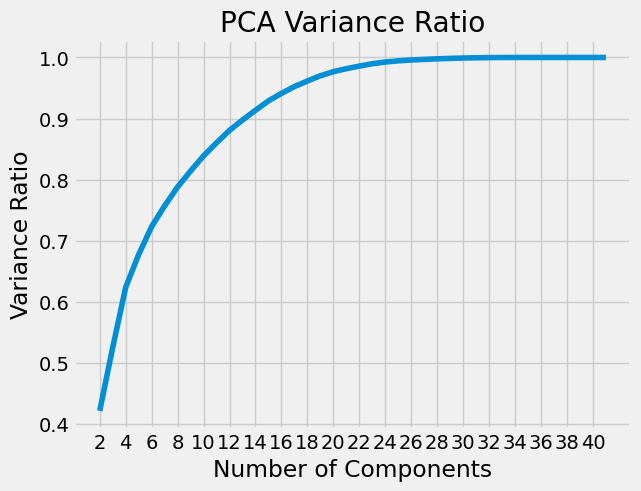

In [425]:
#Useful graph for visualization of ratio changes
plt.style.use('fivethirtyeight')
pca_fig, ax = plt.subplots()
ax.plot(range(2,len(df.columns)), variance_list)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('PCA Variance Ratio')
pca_fig.savefig('../images/PCA_Variance_Ratio.png')

In [426]:
from numpy import diff
diff_variance = diff(variance_list)
print(diff_variance)

[1.03531624e-01 9.84880180e-02 5.36699558e-02 4.57170888e-02
 3.39026294e-02 3.08857267e-02 2.61338844e-02 2.47452248e-02
 2.13734841e-02 2.03991606e-02 1.68408315e-02 1.59436376e-02
 1.54205173e-02 1.21578281e-02 1.12147349e-02 9.11759519e-03
 8.56860303e-03 6.61960441e-03 4.93383433e-03 4.24123128e-03
 3.94208102e-03 2.70922869e-03 1.96885553e-03 1.40181785e-03
 9.73633494e-04 8.99823377e-04 7.28727023e-04 5.90596421e-04
 4.10712413e-04 3.16409562e-04 1.12736491e-04 7.88005185e-05
 1.62016775e-05 5.11075373e-07 8.08556888e-08 5.55055246e-09
 3.28101635e-09 8.28494495e-10 0.00000000e+00]


This calculates the difference between consecutive elements in the variance_list array. Slope calculus, used to determine the "elbow point" in PCA which is where the rate of variance slows down

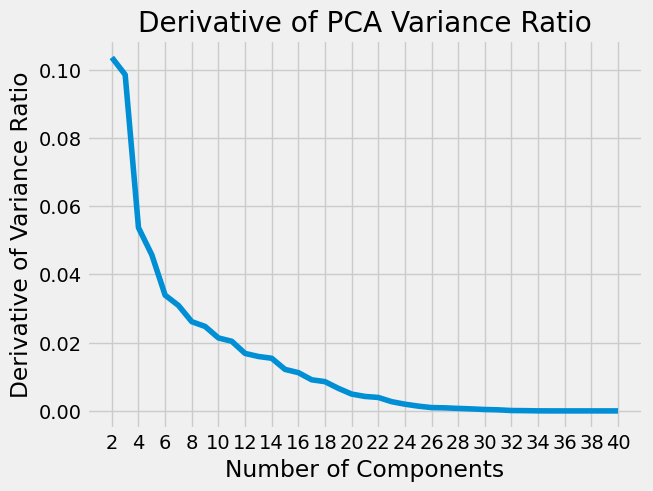

In [427]:
pca_deriv, ax = plt.subplots()
ax.plot(range(2, len(df.columns) - 1), diff_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Derivative of Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('Derivative of PCA Variance Ratio')
pca_deriv.savefig('../images/PCA_Derivative.png')

Good data should have a high PCA Variance Ratio along with a low Derivative of the Variance Ratio. By using both criteria, you balance data representativeness (high variance ratio) and computational efficiency (low derivative).

In [428]:
n_comp = 16
pca = PCA(n_components=n_comp)

# Reducing the dimensions of the data
components = pca.fit_transform(x)

pca_df = pd.DataFrame(data = components, columns = [f'PC{i}' for i in range(1, n_comp + 1)])

pca_df['PLAYER'] = dfPlayerCol['PLAYER']
pca_df = pca_df[['PLAYER'] + [f'PC{i}' for i in range(1, n_comp + 1)]]
pca_df

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.21307953 0.20886503 0.10353162 0.09848802 0.05366996 0.04571709
 0.03390263 0.03088573 0.02613388 0.02474522 0.02137348 0.02039916
 0.01684083 0.01594364 0.01542052 0.01215783]
0.9411541711790883


In [429]:
x = np.column_stack([pca_df[f'PC{i}'] for i in range(1, n_comp)])

# We want a high silhouette score along with meaningful analysis
silhouette = []

for n_clusters in range(2, 32):
    kmeans = KMeans(n_clusters=n_clusters, random_state = 4)
    cluster_labels = kmeans.fit_predict(x)
    centers = kmeans.cluster_centers_
    score = silhouette_score(x, cluster_labels)
    silhouette.append(score)
    print(f"Silhouette Score with {n_clusters} clusters: {score}")

Silhouette Score with 2 clusters: 0.14512799065851123
Silhouette Score with 3 clusters: 0.1840403714086757
Silhouette Score with 4 clusters: 0.13747840549677726
Silhouette Score with 5 clusters: 0.1220312526684909
Silhouette Score with 6 clusters: 0.10840550817751742
Silhouette Score with 7 clusters: 0.10121704711985414
Silhouette Score with 8 clusters: 0.10377909969588112
Silhouette Score with 9 clusters: 0.10703162935055421
Silhouette Score with 10 clusters: 0.09503858538262777
Silhouette Score with 11 clusters: 0.09130954781709107
Silhouette Score with 12 clusters: 0.09108308131763866
Silhouette Score with 13 clusters: 0.09084881342171879
Silhouette Score with 14 clusters: 0.0832623739365662
Silhouette Score with 15 clusters: 0.08816341161491231
Silhouette Score with 16 clusters: 0.08092803296717982
Silhouette Score with 17 clusters: 0.07906771243420971
Silhouette Score with 18 clusters: 0.08075271112278937
Silhouette Score with 19 clusters: 0.08296078393011266
Silhouette Score with

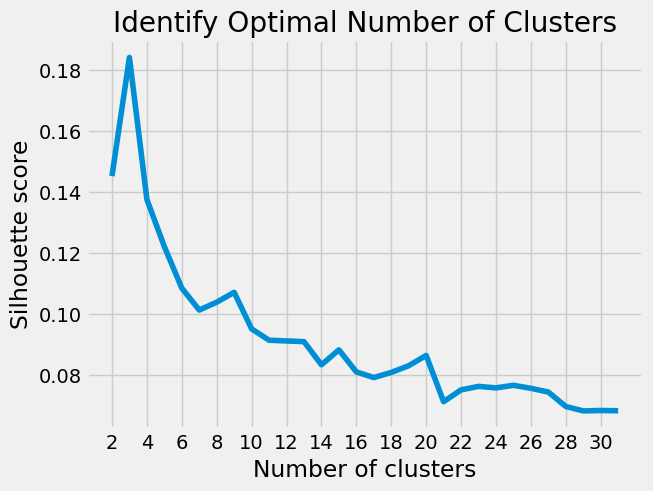

In [430]:
plt.style.use('fivethirtyeight')
silhouette_fig, ax = plt.subplots()
ax.plot(range(2,2 + len(silhouette)), silhouette)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_xticks(np.arange(2, 2+len(silhouette), 2))
ax.set_title('Identify Optimal Number of Clusters')
silhouette_fig.savefig('../images/Optimal_Clusters.png')

In [431]:
silhouette_diff = []

for i in range(1, len(silhouette)):
    improvement = 1 - ((1-silhouette[i]) / (1 - silhouette[i - 1]))
    silhouette_diff.append(improvement)
    print(f"for n_cluseter = {i + 2}, improvement = {improvement}") 

for n_cluseter = 3, improvement = 0.04551837038171225
for n_cluseter = 4, improvement = -0.05706405596595898
for n_cluseter = 5, improvement = -0.01790929401272945
for n_cluseter = 6, improvement = -0.015519623599800747
for n_cluseter = 7, improvement = -0.008062478092444758
for n_cluseter = 8, improvement = 0.0028505798511386793
for n_cluseter = 9, improvement = 0.0036291606830072265
for n_cluseter = 10, improvement = -0.013430536133328008
for n_cluseter = 11, improvement = -0.0041206591853568675
for n_cluseter = 12, improvement = -0.0002492229327473172
for n_cluseter = 13, improvement = -0.0002577440149968968
for n_cluseter = 14, improvement = -0.00834453014762615
for n_cluseter = 15, improvement = 0.005346172709624342
for n_cluseter = 16, improvement = -0.007934950998782497
for n_cluseter = 17, improvement = -0.002024129338833003
for n_cluseter = 18, improvement = 0.0018296662103501893
for n_cluseter = 19, improvement = 0.0024020444052875733
for n_cluseter = 20, improvement = 0.0036

C:\conda_tmp\ipykernel_26644\1289475222.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


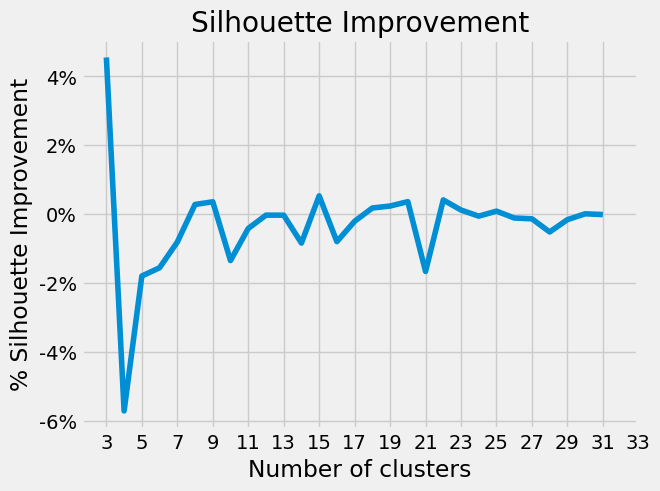

In [432]:
plt.style.use('fivethirtyeight')
silhouette_improvement_fig, ax = plt.subplots()
ax.plot(range(3, 2 + len(silhouette)), silhouette_diff)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('% Silhouette Improvement')
ax.set_xticks(np.arange(3, 4 + len(silhouette), 2))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title('Silhouette Improvement')
silhouette_fig.savefig('../images/Silhouette_Improvement.png')

In [433]:
kmeans = KMeans(n_clusters = 15, random_state = 4)

kmeans.fit(x)

y_kmeans = kmeans.predict(x)
with open("../models/clusterMode.sav", 'wb') as f:
    pickle.dump(kmeans, f)

In [434]:
df_cluster = pd.DataFrame()

df_cluster['Player'] = dfPlayerCol['PLAYER']
df_cluster['Cluster'] = y_kmeans
df_cluster.head()

,Player,Cluster
0,Anthony Black,12
1,Kentavious Caldwell-Pope,9
2,Bennedict Mathurin,13
3,Clint Capela,4
4,De'Aaron Fox,1


In [435]:
pd.DataFrame.to_excel(df_cluster, '../data/clusteredPlayers.xlsx')